# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [303]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale, resize
import datetime
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [304]:
np.random.seed(30)
rn.seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [305]:

parent_folder = 'C:\\Users\\ncjan\\source\\repos\\ncjpersonal\\Gesture Recognition Assignment\\Project_data\\Project_data'

train_folder = parent_folder + '\\train'
val_folder = parent_folder + '\\val'

In [306]:
train_doc = np.random.permutation(open(parent_folder + '\\train.csv').readlines())
val_doc = np.random.permutation(open(parent_folder + '\\val.csv').readlines())
batch_size = 32

enable_augmentation = False 
seq_idx = range(7,26,2)

dim_x, dim_y = 120, 120

In [307]:
datagen = ImageDataGenerator(
    brightness_range=[0.2,1.0],
	rotation_range=15,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	fill_mode="nearest")

In [308]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [309]:
def crop_image(image):
     if image.shape[1] > image.shape[0]:
        diff_px = image.shape[1] - image.shape[0]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[0]
        image = image[:, crop_start:crop_end]
     elif image.shape[0] > image.shape[1]:
        diff_px = image.shape[0] - image.shape[1]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[1]
        image = image[:, crop_start:crop_end]

     return image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [310]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmentation = False, debug=False):
    img_idx =  seq_idx #images to read
    x = len(img_idx)
    y, z = dim_x, dim_y
    
    while True:
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                if debug:
                    plt.figure(figsize=(20,5))
              
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) 
               
                for idx,item in enumerate(img_idx): 
                    filename = source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]

                    image = io.imread(filename).astype(np.float32)

                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
       
                    image = crop_image(image=image)

                    resized_im = resize(image, output_shape=(120,120))
                
                    if augmentation==True and is_train==True:
                        resized_im = next(datagen.flow(np.expand_dims(resized_im, axis=0), batch_size=1))[0]
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))

                    #Normalize images
                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

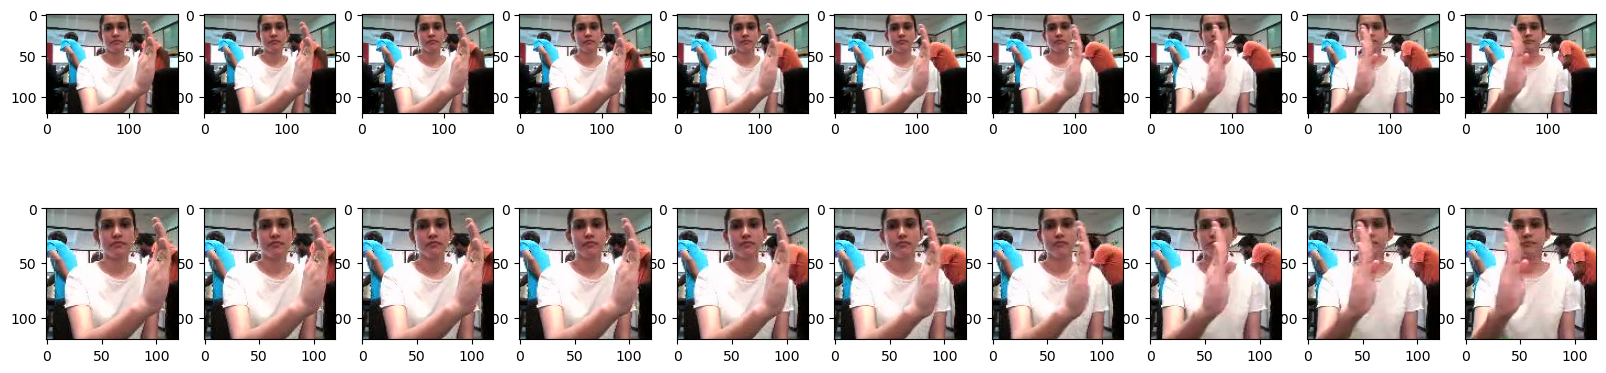

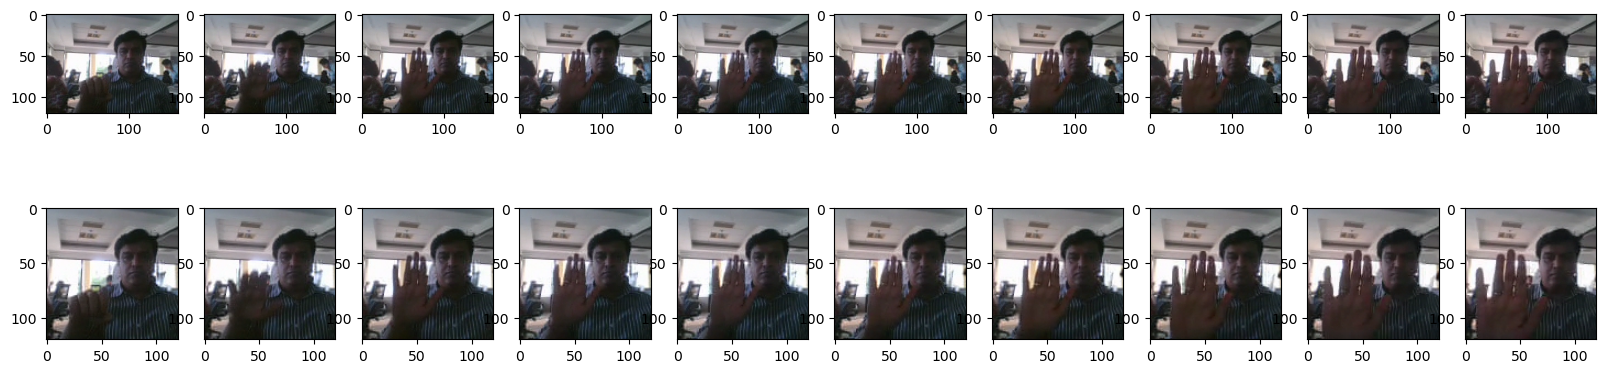

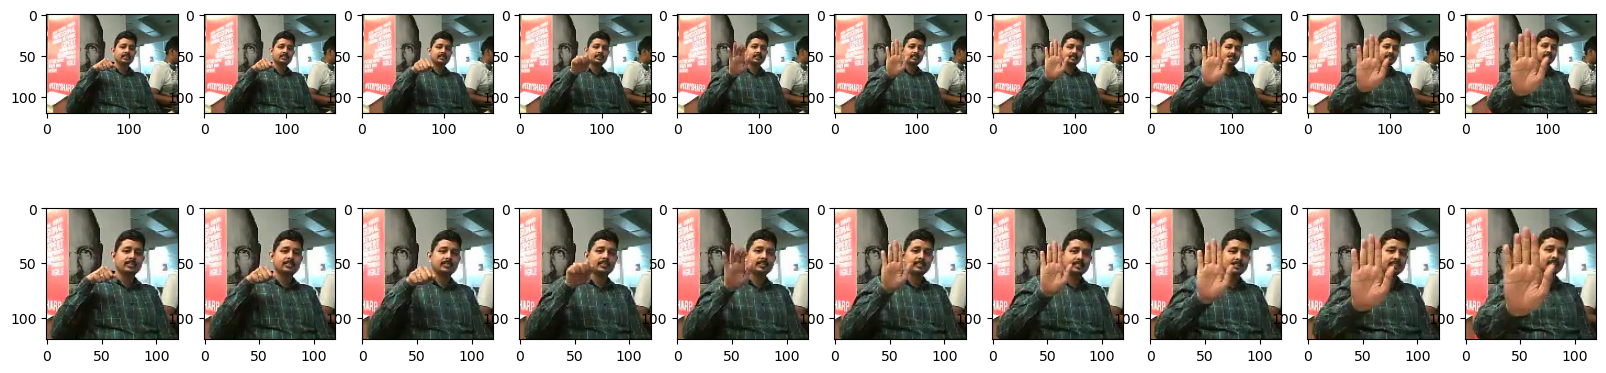

In [311]:
test_gen = generator(train_folder, train_doc, 3, is_train = True, augmentation=False, debug = True)

xx = next(test_gen)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [312]:
curr_dt_time = datetime.datetime.now()
train_path = train_folder
val_path =  val_folder

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [313]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [314]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [315]:
optimiser = optimizers.Adam(lr=0.01) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_41 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_26 (MaxPooli  (None, 3, 58, 58, 64)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_10 (Ba  (None, 3, 58, 58, 64)     256       
 tchNormalization)                                               
                                                                 
 conv3d_42 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 1, 28, 28, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [316]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [325]:
model_name = 'model_init_exp_02' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [318]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [319]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.1564 - categorical_accuracy: 0.4464
Epoch 1: saving model to model_init_exp_01_2024-01-3013_53_58.839738\model-00001-2.15639-0.44643-13.93727-0.13281.h5
21/21 [==============================] - 148s 7s/step - loss: 2.1564 - categorical_accuracy: 0.4464 - val_loss: 13.9373 - val_categorical_accuracy: 0.1328 - lr: 0.0010
Epoch 2/30


c:\Users\ncjan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.7574 - categorical_accuracy: 0.7113
Epoch 2: saving model to model_init_exp_01_2024-01-3013_53_58.839738\model-00002-0.75745-0.71131-5.15692-0.16406.h5
21/21 [==============================] - 102s 5s/step - loss: 0.7574 - categorical_accuracy: 0.7113 - val_loss: 5.1569 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.4899 - categorical_accuracy: 0.8170
Epoch 3: saving model to model_init_exp_01_2024-01-3013_53_58.839738\model-00003-0.48987-0.81696-2.94632-0.14844.h5
21/21 [==============================] - 102s 5s/step - loss: 0.4899 - categorical_accuracy: 0.8170 - val_loss: 2.9463 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.3038 - categorical_accuracy: 0.8839
Epoch 4: saving model to model_init_exp_01_2024-01-3013_53_58.839738\model-00004-0.30375-0.88393-2.03576-0.21094.h5
21/21 [====

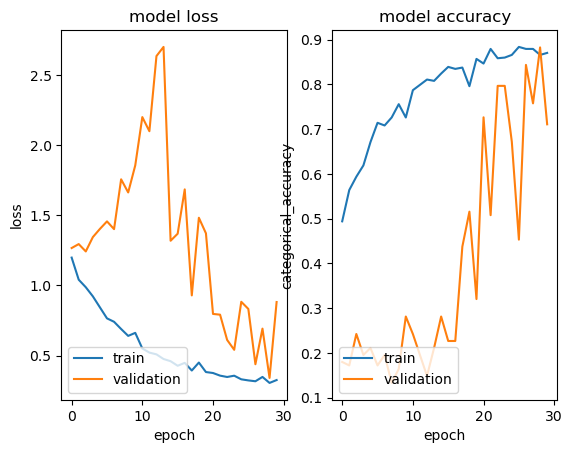

In [328]:
def plot_history(history):
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

plot_history(history)

### RNN + CNN

In [321]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [322]:
optimiser = optimizers.Adam(lr=0.01) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 118, 118, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization_15 (Ba  (None, 10, 118, 118, 8)   32        
 tchNormalization)                                               
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_16 (Ba  (None, 10, 116, 116, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)     

In [326]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.1980 - categorical_accuracy: 0.4940
Epoch 1: saving model to model_init_exp_02_2024-01-3013_53_58.839738\model-00001-1.19804-0.49405-1.26625-0.17969.h5
21/21 [==============================] - 65s 3s/step - loss: 1.1980 - categorical_accuracy: 0.4940 - val_loss: 1.2662 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0405 - categorical_accuracy: 0.5640
Epoch 2: saving model to model_init_exp_02_2024-01-3013_53_58.839738\model-00002-1.04045-0.56399-1.29432-0.17188.h5
21/21 [==============================] - 102s 5s/step - loss: 1.0405 - categorical_accuracy: 0.5640 - val_loss: 1.2943 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9868 - categorical_accuracy: 0.5938
Epoch 3: saving model to model_init_exp_02_2024-01-3013_53_58.839738\model-00003-0.98678-0.59375-1.24195-0.24219.h5
2

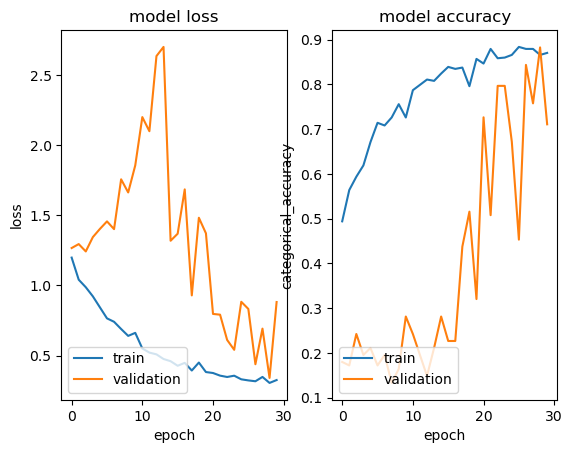

In [329]:
plot_history(history)